# Breaking a CAPTCHA system

Ref: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710

In [2]:
%%javascript
IPython.notebook.clear_all_output();

<IPython.core.display.Javascript object>

Install some packages below (if not installed already):

In [3]:
!pip install opencv-python
!pip install imutils
!conda install pydot -y
!conda install graphviz -y


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip



CondaSSLError: OpenSSL appears to be unavailable on this machine. OpenSSL is required to
download and install packages.

Exception: HTTPSConnectionPool(host='repo.anaconda.com', port=443): Max retries exceeded with url: /pkgs/main/win-64/current_repodata.json (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available."))





CondaSSLError: Encountered an SSL error. Most likely a certificate verification issue.

Exception: HTTPSConnectionPool(host='repo.anaconda.com', port=443): Max retries exceeded with url: /pkgs/main/win-64/current_repodata.json (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available."))




In [4]:
!brew install graphviz # only for mac, for other OS, please search the relevant command to install
!brew install wget # only for mac; Linux should work fine, Windows has no wget

'brew' is not recognized as an internal or external command,
operable program or batch file.
'brew' is not recognized as an internal or external command,
operable program or batch file.


In this exercise you will break `Really Simple CAPTCHA` plugin of WordPress: https://wordpress.org/plugins/really-simple-captcha/

Try a demo here: https://contactform7.com/captcha/

The plugin generates 4-letter CAPTCHAs using a random mix of four different fonts. Letters are from 'ABCDEFGHJKLMNPQRSTUVWXYZ23456789' and "O", "I" and "1" are not used to avoid user confusion. That leaves us with a total of 32 possible letters and numbers that we need to recognize.

Since we have the source code to the WordPress plug-in, we can modify it to save out CAPTCHA images along with the expected answer for each image. We generated 9955 images under folder `generated_captcha_images`. Run the following code to show 10 images to take a look.

In [5]:
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"

## Step 1: Extract single letters from CAPTCHA images

### Run the following code to show 10 images to take a look.

In [6]:
import os.path
import glob # glob.glob returns the list of files with their full path, and it supports wildcards

from IPython.display import Image

captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))

for (i, captcha_image_file) in enumerate(captcha_image_files):
    if i==10: break
    print(captcha_image_file)
    display(Image(filename=captcha_image_file))

generated_captcha_images\222X.png


generated_captcha_images\226U.png


generated_captcha_images\2274.png


generated_captcha_images\22A6.png


generated_captcha_images\22BJ.png


generated_captcha_images\22HS.png


generated_captcha_images\22KD.png


generated_captcha_images\22L9.png


generated_captcha_images\22NR.png


generated_captcha_images\22PL.png


### Now we illustrate how to process an image `generated_captcha_images/222X.png`

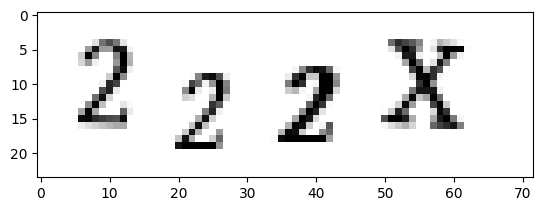

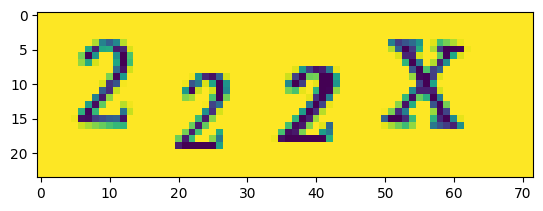

In [7]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt
import cv2 # OpenCV, a popular framework for computer vision and image processing

captcha_image_file = 'generated_captcha_images/222X.png' # normal
# captcha_image_file = 'generated_captcha_images/2W4M.png' # try this: 3 objects, 2 letters are merged
# captcha_image_file = 'generated_captcha_images/3PH3.png' # try this: 5 objects detected
# captcha_image_file = 'generated_captcha_images/JYU4.png' # try this: 6 objects detected

captcha_correct_text = os.path.splitext(captcha_image_file)[0]

# Load the image and convert it to grayscale
image = cv2.imread(captcha_image_file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#Show the image with matplotlib
plt.imshow(image)
plt.show()

plt.imshow(gray)
plt.show()

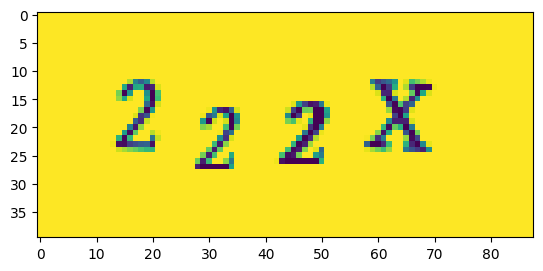

In [8]:
# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

plt.imshow(gray)
plt.show()

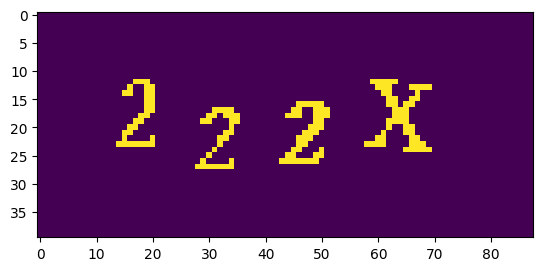

In [9]:
# threshold the image (convert it to pure black and white)
# we use Otsu’s binarization
# check: https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

plt.imshow(thresh)
plt.show()

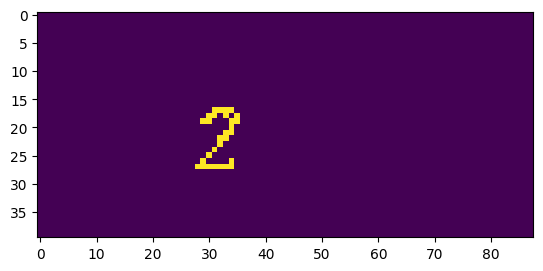

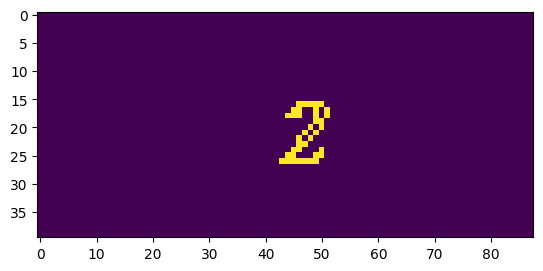

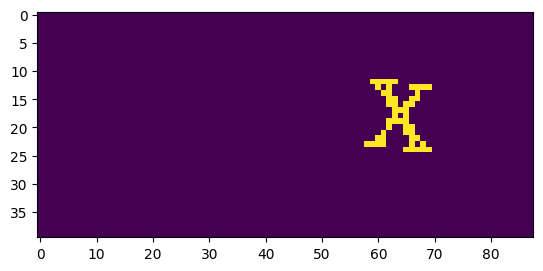

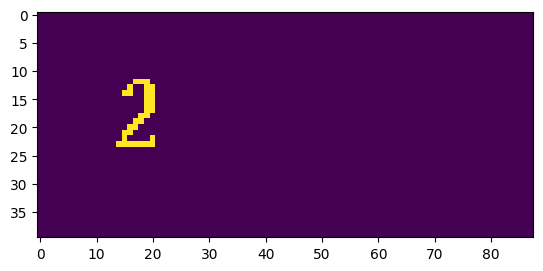

In [10]:
import numpy as np

# find the contours (continuous blobs of pixels) the image
# check:
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html#contours-getting-started
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# !!! if the cell reports error, replace [0] above with [1]

zero_img = np.zeros_like(thresh)

for i in range(len(contours)):
    temp = cv2.drawContours(zero_img.copy(), contours, i, (255,0,0), 1)
    plt.imshow(temp)
    plt.show()

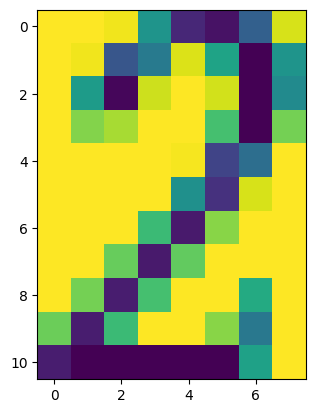

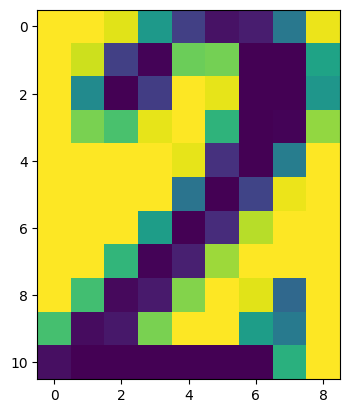

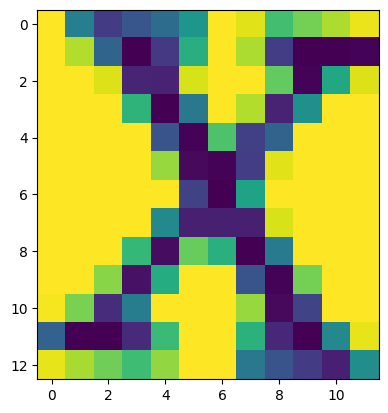

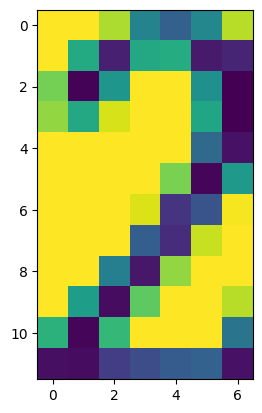

In [11]:
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    letter_image = gray[y:y+h, x:x+w]
    plt.imshow(letter_image)
    plt.show()

### Putting things together: get letters from images

Using what we have learnt above, write your code to save get the letters of all images. The letter-images are stored as 32 folders under folder `extracted_letter_images`.

For example, `extracted_letter_images/A` is a folder that saves all images of letter `A`. After you complete, each letter-folder should contain over 1000 letter-images.

Hint: (1) consider how to name different files in a letter-folder differently? (2) ingore those images with number of contours other than 4.

In [12]:
import os
import cv2

LETTER_IMAGES_FOLDER = "extracted_letter_images" # the output for training
SKIPPED_FOLDER = "skipped_images" # those images are skipped
counts = {} # counts['A'] = number of 'A'-images, so that next 'A'-image can be named as counts['A'] + 1

# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

    # load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # threshold the image to reveal the digits
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # find contours in the thresholded image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    letter_image_regions = []
    for contour in contours:
        # get the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # check if the aspect ratio of the bounding box is within acceptable range
        aspect_ratio = w / h
        if aspect_ratio < 1.25 and aspect_ratio > 0.75:
            letter_image_regions.append((x, y, w, h))

    # sort the letters top-to-bottom and then left-to-right
    letter_image_regions = sorted(letter_image_regions, key=lambda x: (x[1], x[0]))

    for letter_bounding_box, letter in zip(letter_image_regions, captcha_correct_text):
        # get the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box
        
        # extract the letter from the original image with a 2-pixel margin
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        
        # get the folder to save the letter images
        folder = os.path.join(LETTER_IMAGES_FOLDER, letter)
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        # write the letter image to disk
        count = counts.get(letter, 1)
        p = os.path.join(folder, "{}.png".format(str(count).zfill(6)))
        if letter_image.size == 0:
           print("Empty image detected, skipping")
        else:
           cv2.imwrite(p, letter_image)

        
        # increment the count for the current letter
        counts[letter] = count + 1


[INFO] processing image 1/9955
[INFO] processing image 2/9955
[INFO] processing image 3/9955
[INFO] processing image 4/9955
[INFO] processing image 5/9955
[INFO] processing image 6/9955
[INFO] processing image 7/9955
[INFO] processing image 8/9955
[INFO] processing image 9/9955
[INFO] processing image 10/9955
[INFO] processing image 11/9955
[INFO] processing image 12/9955
[INFO] processing image 13/9955
[INFO] processing image 14/9955
[INFO] processing image 15/9955
[INFO] processing image 16/9955
[INFO] processing image 17/9955
[INFO] processing image 18/9955
[INFO] processing image 19/9955
[INFO] processing image 20/9955
[INFO] processing image 21/9955
[INFO] processing image 22/9955
[INFO] processing image 23/9955
[INFO] processing image 24/9955
[INFO] processing image 25/9955
[INFO] processing image 26/9955
[INFO] processing image 27/9955
[INFO] processing image 28/9955
[INFO] processing image 29/9955
[INFO] processing image 30/9955
[INFO] processing image 31/9955
[INFO] processing

Now, folder `extracted_letter_images` should contain 32 folders, each storing the corresponding letter images

## Step 2: Train the neural network to recognize single letters

Since input layer of a neural network model takes images of fixed size (usually square), we need to resize images first.

(17, 16)


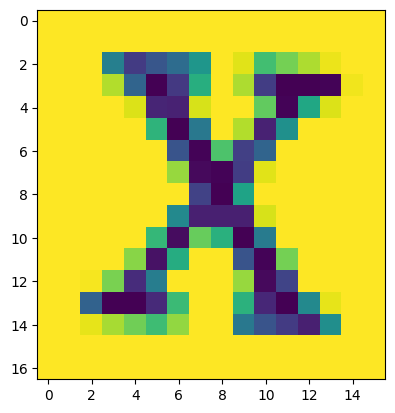

In [14]:
letter_image_file = 'extracted_letter_images/g/000001.png'

image = cv2.imread(letter_image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape) 
(h, w) = image.shape[:2] # note that cv.imread gets an array of h x w, h goes first
# add [:2] so that even if color image will work, not needed here though

plt.imshow(image)
plt.show()

Since `h > w`, we make sure `h` fits in our desired height value, e.g., 20:

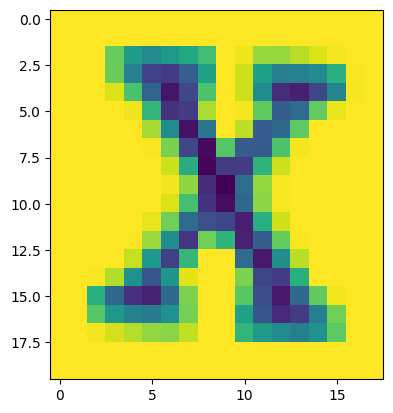

In [15]:
import imutils

image = imutils.resize(image, height=20)
# imutils.resize maintains the aspect ratio

plt.imshow(image)
plt.show()

Now we pad along width to make the image square, i.e., 20 x 20:

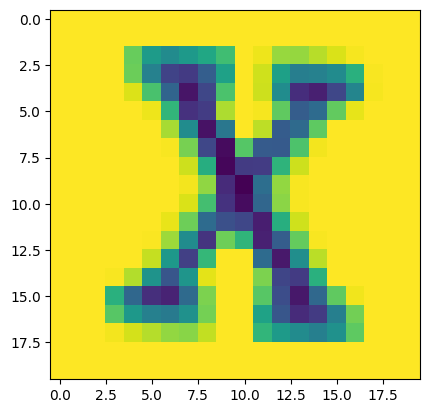

In [16]:
# determine the padding values for the width (= 20)
# to obtain the target dimensions
padW = int((20 - image.shape[1]) / 2.0) # may have rounding

# pad the image
image = cv2.copyMakeBorder(image, 0, 0, padW, padW,
        cv2.BORDER_REPLICATE)

# apply one more resizing to handle any rounding issues
image = cv2.resize(image, (20, 20))

plt.imshow(image)
plt.show()

Using what you learned, now write a function to resize images. Note that you also need to handle the possible case `h < w`:

In [17]:
def resize_to_fit(image, width, height):
    #############################################################################
# TODO: your code here ...                                                  #
#############################################################################
    (h, w) = image.shape[:2]

# if the width is smaller than the height, then resize along
# the width (i.e., the smaller dimension) and then update the
# deltas to crop the height to the desired dimension
    if w < h:
        image = imutils.resize(image, width=width)
        delta_h = int((image.shape[0] - height) / 2.0)
        image = image[delta_h:delta_h + height, :]

# otherwise, the height is smaller than the width so resize
# along the height and then update the deltas to crop along
# the width
    else:
        image = imutils.resize(image, height=height)
        delta_w = int((image.shape[1] - width) / 2.0)
        image = image[:, delta_w:delta_w + width]

#############################################################################
#                              END OF YOUR CODE                             #
#############################################################################

# return the pre-processed image
    return image


Prepare the training and validating datasets:

In [18]:
from imutils import paths

# initialize the data and labels
data_labels = []

progress_folder = ''

# loop over the input images
# imutils.paths.list_images will list all images in the 32 subfolders
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]
    # extracted_letter_images/2/000001.png, after split
    # extracted_letter_images, 2, 000001.png
    # so 2 is the 2nd last, accessed using index -2
    
    if label != progress_folder:
        print('Processing Folder', label)
        progress_folder = label
    
    # Add the letter image and it's label to our training data
    data_labels.append((image,label))

Processing Folder e
Processing Folder g
Processing Folder n
Processing Folder r


In [19]:
# shuffling training data, as we will use part of it for validation and we need labels to be balanced

import random

random.shuffle(data_labels)
data = [x[0] for x in data_labels]
labels = [x[1] for x in data_labels]

Convert lists into NumPy arrays as required by Keras for input + data normalization:

In [20]:
# scale the raw pixel intensities to the range [0, 1] (this is important!!!)
data = np.array(data, dtype="float") / 255.0

# you may also use std rather than 255, and center the data by mean as follows:
#data = (np.array(data, dtype="float") - data.mean()) / data.std()
# in this case you need to remember the mean and std for use during testing later

# scaling is not needed if you use BatchNormalization after Conv2D and before Activation

labels = np.array(labels)

Split into training and validation datasets:

In [21]:
from sklearn.preprocessing import LabelBinarizer

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(labels)
print(lb.classes_)
labels = lb.transform(labels)
print()
print(labels)

['e' 'g' 'n' 'r']

[[1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]]


In [22]:
import pickle

MODEL_LABELS_FILENAME = "model_labels.dat"

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

Now we are ready to train it using Keras. We’ll use a simple convolutional neural network architecture with two convolutional layers and two fully-connected layers:

In [23]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

clear_session() # free existing Keras models

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

ImportError: Could not find the DLL(s) 'msvcp140_1.dll'. TensorFlow requires that these DLLs be installed in a directory that is named in your %PATH% environment variable. You may install these DLLs by downloading "Microsoft C++ Redistributable for Visual Studio 2015, 2017 and 2019" for your platform from this URL: https://support.microsoft.com/help/2977003/the-latest-supported-visual-c-downloads

In [ ]:
model.summary()

In [ ]:
# from tensorflow.keras.utils import plot_model
from keras.utils import plot_model # if does not work properly, try the previous line instead

MODEL_PLOT_FILE = 'model_plot.png'
plot_model(model, to_file=MODEL_PLOT_FILE, show_shapes=True, show_layer_names=True)
display(Image(filename=MODEL_PLOT_FILE))

Questions: (1) Why `conv2d_1` has 9050 parameters? (2) Why `dense` has 625500 parameters?

Hint: self-study http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture5.pdf
    
**Type Your Answer Here:**


Now, let us do the actual training:

In [ ]:
# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the neural network, 20% of the data is used for validation
model.fit(data, labels, validation_split=0.20, batch_size=32, epochs=10, verbose=1)

Save the model for later use:

In [ ]:
MODEL_FILENAME = "captcha_model.hdf5"

# Save the trained model to disk
model.save(MODEL_FILENAME)

In [1]:
#See what will happen if you do not scale your data by 255.0?
#HINT: simply train again with data/255.0 instead of 255, and see how the loss and acc look like;
#      you need to recreate your model by running the cell containing clear_session() before

#[YOUR CODE HERE]
clear_session() # free existing Keras models

# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

model.summary()

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network, 20% of the data is used for validation
model.fit(data, labels, validation_split=0.20, batch_size=32, epochs=10, verbose=1)
MODEL_FILENAME = "captcha_model.hdf5"

# Save the trained model to disk
model.save(MODEL_FILENAME)


NameError: name 'clear_session' is not defined

## Step 3: Use the model to solve CAPTCHAs!

The rest part can be run independently once models are saved.

Get an image from the online demo: https://contactform7.com/captcha/ and try our model on it:

In [ ]:
# replace the url with the link of the image you see
# [Using the same image will cause points deducted !!!]
!wget https://contactform7.com/wp-content/uploads/wpcf7_captcha/4034640145.png
# use the name of the file you downloaded
TEST_FILE_NAME = '4034640145.png'

# show the image
from IPython.display import Image

display(Image(filename=TEST_FILE_NAME))

Load saved model data:

In [ ]:
from tensorflow.keras.models import load_model
import pickle

MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"

# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    lb = pickle.load(f)

# Load the trained neural network
model = load_model(MODEL_FILENAME)

Load packages and define functions for independent running of Part 3:

In [ ]:
import numpy as np
import imutils
import cv2

# [!!! please also run the cell defining function "resize_to_fit" again, if you run Part 3 alone]

Get the letters from the downloaded images:

In [ ]:
# Load the image and convert it to grayscale
image = cv2.imread(TEST_FILE_NAME)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add some extra padding around the image
gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

# threshold the image (convert it to pure black and white)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# find the contours (continuous blobs of pixels) the image
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# !!! if the cell reports error, replace [0] above with [1]

letter_image_regions = []

# Now we can loop through each of the four contours and extract the letter
# inside of each one
for contour in contours:
    # Get the rectangle that contains the contour
    (x, y, w, h) = cv2.boundingRect(contour)
    letter_image_regions.append((x, y, w, h))

# If we found more or less than 4 letters in the captcha, our letter extraction
# didn't work correcly. Skip the image instead of saving bad training data!
if len(letter_image_regions) != 4:
    print('[WARNING]', TEST_FILE_NAME, 'has', len(letter_image_regions), 'contours, unable to process')
else:
    print('[SUCCESS]')

If you see a warning, use another image instead and repeat the previous steps.

Otherwise, continue to create an output image:

In [ ]:
# Sort the detected letter images based on the x coordinate to make sure
# we are processing them from left-to-right so we match the right image
# with the right letter
letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

# Create an output image and a list to hold our predicted letters
output = cv2.merge([gray] * 3) # 2D gray image -> 3D color image

# show the 3D image
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(output)
plt.show()

In [ ]:
predictions = []

# Save out each letter as a single image
for letter_bounding_box in letter_image_regions:
    # Grab the coordinates of the letter in the image
    x, y, w, h = letter_bounding_box

    # Extract the letter from the original image with a 2-pixel margin around the edge
    letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

    # Re-size the letter image to 20x20 pixels to match training data
    letter_image = resize_to_fit(letter_image, 20, 20)
    
    # Turn the single image into a 4D list of images to make Keras happy
    # 4D: image_number (=1) x height x width x channel (=1)
    letter_image = np.expand_dims(letter_image, axis=2)
    letter_image = np.expand_dims(letter_image, axis=0)
    
    # Ask the neural network to make a prediction
    prediction = model.predict(letter_image) # output is one-hot encoded
        
    letter = lb.inverse_transform(prediction)[0]
    # use [0] since there is only one test data's label item in the list
    predictions.append(letter)
    
    # draw the prediction on the output image
    # (255, 0, 0) = red
    cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (255, 0, 0), 1)
    cv2.putText(output, letter, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 0, 0), 1)

# see prediction result:

# Print the captcha's text
captcha_text = "".join(predictions)
print("CAPTCHA text is: {}".format(captcha_text))

# Show the annotated image
plt.imshow(output)
plt.show()

Questions: Is the prediction correct? How many letters are correctly predicted?
    
**Type Your Answer Here:**